# Import Libraries

In [8]:
#!pip3 install h2o
#!pip3 install impyute

In [9]:
import h2o
import numpy as np
import pandas as pd
import impyute as impy

from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

# Initialize H2O

In [10]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,23 hours 38 mins
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,21 days and 27 minutes
H2O_cluster_name:,H2O_from_python_pranjal_singh_qzstlc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.230 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


# Read Data

In [12]:
# use low_memory=False to avoid warning which happens when pandas tries to guess data types for each column
data = pd\
    .read_csv("input/LoansTrainingSetV2.csv", low_memory=False)\
    .drop_duplicates()\
    .sort_values(by="Loan ID")\
    .reset_index(drop=True)

In [13]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Loan Given,11731,Short Term,746.0,4 years,Rent,50025.0,Debt Consolidation,355.18,11.5,NaN,12,0,17391,37081,0.0,0.0
1,0000afa6-8902-4f8f-b870-25a8fdad0aeb,e49c1a82-a0f7-45e8-9f46-2f75c43f9fbc,Loan Refused,24613,Long Term,NaN,6 years,Rent,NaN,Business Loan,542.29,17.6,73.0,7,0,14123,16954,0.0,0.0
2,00020fb0-6b8a-4b3a-8c72-9c4c847e8cb6,c9decd06-16f7-44c3-b007-8776f2a9233d,Loan Given,99999999,Short Term,742.0,3 years,Home Mortgage,64760.0,Debt Consolidation,582.84,26.8,NaN,11,0,8880,22711,0.0,0.0
3,00045ecd-59e9-4752-ba0d-679ff71692b3,b7bce684-b4b0-4b29-af66-eae316bce573,Loan Given,11863,Short Term,734.0,10+ years,Own Home,69202.0,Debt Consolidation,859.26,30.3,NaN,7,0,9959,16995,0.0,0.0
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719,Short Term,NaN,1 year,Own Home,NaN,Home Improvements,777.38,13.6,2.0,12,0,6720,53335,0.0,0.0


# Exploratory Data Analysis & Feature Engineering

In [14]:
# Check the target column value counts
data['Loan Status'].value_counts()

Loan Given      73411
Loan Refused    25173
Name: Loan Status, dtype: int64

##### Loan Amount has extreme value present, replace it with NA for data imputation

count    9.858400e+04
mean     1.293320e+07
std      3.353863e+07
min      4.910000e+02
25%      8.193750e+03
50%      1.426000e+04
75%      2.420200e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64
34773.0


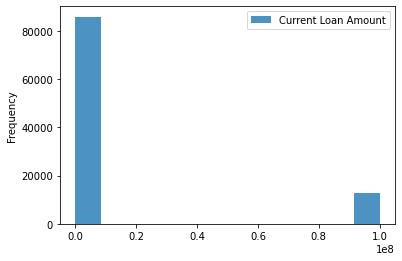

In [15]:
print(data['Current Loan Amount'].describe())
print(np.quantile(data['Current Loan Amount'], 0.85))
data[['Current Loan Amount']].plot.hist(bins=12, alpha=0.8)

loan_amount_threshold = data['Current Loan Amount'].max() / 2.0

In [16]:
data['Current Loan Amount'] = np.where(data['Current Loan Amount'] 
                                       > loan_amount_threshold, np.nan, data['Current Loan Amount'])

##### Loan ID is not unique, duplicate rows present due to null values in Credit Score and Annual Income. 

Solution: Merge them using max aggregate function

In [17]:
data['Loan ID'].unique().shape

(88910,)

In [18]:
data.groupby(["Loan ID", "Loan Status"]).filter(lambda x: x['Customer ID'].count() > 1).head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719.0,Short Term,NaN,1 year,Own Home,NaN,Home Improvements,777.38,13.6,2.0,12,0,6720,53335,0.0,0.0
5,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719.0,Short Term,724.0,1 year,Own Home,34297.0,Home Improvements,777.38,13.6,2.0,12,0,6720,53335,0.0,0.0
8,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Loan Given,1433.0,Short Term,716.0,10+ years,Home Mortgage,108735.0,Home Improvements,2627.76,15.1,5.0,22,0,27706,49563,0.0,0.0
9,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Loan Given,1433.0,Short Term,NaN,10+ years,Home Mortgage,NaN,Home Improvements,2627.76,15.1,5.0,22,0,27706,49563,0.0,0.0
22,000dbdf1-3926-4676-bb4f-fe40c242a46e,5165c688-1669-43e9-88b5-db212c72655c,Loan Given,NaN,Long Term,717.0,3 years,Home Mortgage,88880.0,Debt Consolidation,1881.29,25.9,NaN,20,0,37507,50961,0.0,0.0


In [19]:
## Duplicate Loan Ids present
data = data.groupby(["Loan ID"]).agg('max').reset_index()

In [ ]:
data.to_csv('grouped_by_loan_id.csv')

In [20]:
assert data['Loan ID'].unique().shape[0] == data.shape[0]

##### Finding the missing value columns and impute sequentially

In [21]:
data.isna().sum()

Loan ID                             0
Customer ID                         0
Loan Status                         0
Current Loan Amount              8316
Term                                0
Credit Score                    16089
Years in current job             3817
Home Ownership                      0
Annual Income                   16089
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    48506
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                      192
Tax Liens                           8
dtype: int64

### Loan Amount Imputation
data['Current Loan Amount'].fillna(data['Current Loan Amount'].median(), inplace=True)
#### Will impute later

In [22]:
data['Current Loan Amount'].describe()

count    80594.000000
mean     13984.078505
std       8291.958385
min        491.000000
25%       7810.000000
50%      12058.000000
75%      19492.750000
max      35875.000000
Name: Current Loan Amount, dtype: float64

### Annual Income Imputation
data['Annual Income'].fillna(data['Annual Income'].mean(), inplace=True)
#### Will impute later

In [23]:
data['Annual Income'].describe()

count    7.282100e+04
mean     7.240482e+04
std      5.771356e+04
min      4.033000e+03
25%      4.463800e+04
50%      6.158500e+04
75%      8.678500e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

#### Credit Score Imputation
###### - Treat extreme values which have extra 0s by dividing them with 10
###### - Impute using 75th percentile after observing the distribution whihc is right shifted

count    72821.000000
mean      1163.219937
std       1624.254818
min        585.000000
25%        711.000000
50%        731.000000
75%        743.000000
max       7510.000000
Name: Credit Score, dtype: float64


<AxesSubplot:ylabel='Frequency'>

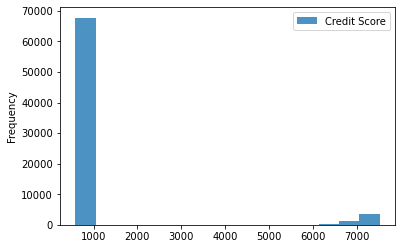

In [24]:
print(data["Credit Score"].describe())
data[['Credit Score']].plot.hist(bins=15, alpha=0.8)

In [25]:
data["Credit Score"] = np.where(data["Credit Score"] > 800, data["Credit Score"] / 10, data["Credit Score"])

In [26]:
### Impute with 75% quantile value
data['Credit Score'].fillna(data["Credit Score"].describe()['75%'], inplace=True)

#### Years in current job Imputation
###### - Convert string to numbers
###### - Impute using 75th percentile after observing the distribution whihc is right shifted

In [27]:
data['Years in current job'].value_counts()

10+ years    27410
2 years       8187
< 1 year      7312
3 years       7263
5 years       6084
1 year        5765
4 years       5474
6 years       5095
7 years       4943
8 years       4098
9 years       3462
Name: Years in current job, dtype: int64

<AxesSubplot:ylabel='Frequency'>

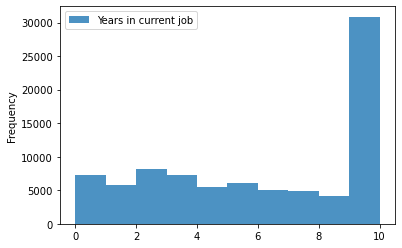

In [28]:
years_dict = {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, 
              '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10}
data.replace({"Years in current job": years_dict}, inplace=True)
data[['Years in current job']].plot.hist(bins=10, alpha=0.8)

In [29]:
### Impute with 75% quantile value
data['Years in current job'].fillna(data["Years in current job"].describe()['75%'], inplace=True)

#### Delinquent Imputation
###### - Impute using 75th percentile after observing the distribution whihc is right shifted

In [30]:
data['Months since last delinquent'].describe()

count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64

In [31]:
### Impute with 75% quantile value
data['Months since last delinquent'].fillna(data["Months since last delinquent"].describe()['75%'], inplace=True)

#### Term feature binarization
###### - Convert term into numerical/binary feature

In [32]:
data['Term'].value_counts()

Short Term    66932
Long Term     21978
Name: Term, dtype: int64

<AxesSubplot:ylabel='Frequency'>

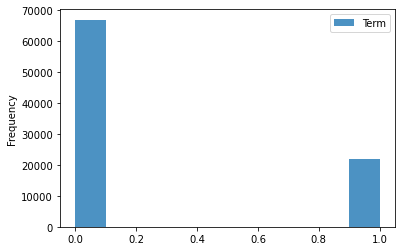

In [33]:
term_dict = {'Short Term':0, 'Long Term':1}
data.replace({"Term": term_dict}, inplace=True)
data[['Term']].plot.hist(bins=10, alpha=0.8)

#### Home Ownership
###### - Feature correction by converting HaveMortgage to Home Mortgage which have same meaning

In [34]:
data['Home Ownership'].value_counts()

Home Mortgage    43270
Rent             37395
Own Home          8075
HaveMortgage       170
Name: Home Ownership, dtype: int64

In [35]:
data['Home Ownership']=data['Home Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

#### Purpose
###### - Feature correction for 'Other'

In [36]:
data['Purpose'].value_counts()

Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [37]:
data['Purpose'] = data['Purpose'].str.replace('Other', 'other', regex=True)

#### Monthly debt
###### - Converting to numeric throws an error due to presence of $. Do feature correction and then convert

In [38]:
data['Monthly Debt'].describe()

count     88910
unique    70064
top           0
freq         69
Name: Monthly Debt, dtype: object

In [39]:
data['Monthly Debt'] = data['Monthly Debt'].str.replace('$', '', regex=True)
data['Monthly Debt'] = pd.to_numeric(data['Monthly Debt'] )

In [40]:
data['Monthly Debt'].describe()

count    88910.000000
mean       963.102059
std        637.524064
min          0.000000
25%        532.220000
50%        843.925000
75%       1250.527500
max      22939.120000
Name: Monthly Debt, dtype: float64

#### Years of credit history
###### - No action required

In [41]:
data['Years of Credit History'].describe()

count    88910.000000
mean        18.315313
std          7.049175
min          3.600000
25%         13.500000
50%         17.000000
75%         21.800000
max         70.500000
Name: Years of Credit History, dtype: float64

#### Maximum Open Credit
###### 1. Conversion to numeric throws an error due to presence of #VALUE, do feature correction
###### 2. Convert to numeric
###### 3. Impute using median
###### 4. Fix outlier by setting it to max value

In [42]:
data['Maximum Open Credit'].describe()

count     88910
unique    46625
top           0
freq        610
Name: Maximum Open Credit, dtype: object

In [43]:
data['Maximum Open Credit'] = data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)
data['Maximum Open Credit'].fillna(data["Maximum Open Credit"].median(), inplace=True)
data['Maximum Open Credit'] = pd.to_numeric(data['Maximum Open Credit'])

In [44]:
data['Maximum Open Credit'].describe()

count    8.891000e+04
mean     3.596499e+04
std      4.041760e+05
min      0.000000e+00
25%      1.277525e+04
50%      2.178100e+04
75%      3.636700e+04
max      6.998809e+07
Name: Maximum Open Credit, dtype: float64

In [45]:
data['Maximum Open Credit'].quantile([0.5,0.75,0.95,0.99,1])

0.50       21781.00
0.75       36367.00
0.95       76600.80
0.99      171423.91
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [46]:
data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423

#### Bnakruptcies
###### - Impute using median

In [47]:
data['Bankruptcies'].value_counts()

0.0    79323
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: Bankruptcies, dtype: int64

In [48]:
### Median imputation
data['Bankruptcies'].fillna(data['Bankruptcies'].median(), inplace=True)

#### Tax Liens
###### 1. Impute using mode which is 0.0

In [49]:
data['Tax Liens'].value_counts()

0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
11.0        1
10.0        1
Name: Tax Liens, dtype: int64

In [50]:
data['Tax Liens'].fillna(0.0, inplace=True)

# Categorical Encoding

In [51]:
dummies = pd.get_dummies(data['Purpose'], prefix='purpose')
data[dummies.columns] = dummies

dummies = pd.get_dummies(data['Home Ownership'], prefix='home')
data[dummies.columns] = dummies

data = data.drop(["Home Ownership", "Purpose"], axis=1)

# Advanced Imputation

In [52]:
data.isna().sum()

Loan ID                             0
Customer ID                         0
Loan Status                         0
Current Loan Amount              8316
Term                                0
Credit Score                        0
Years in current job                0
Annual Income                   16089
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent        0
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                        0
Tax Liens                           0
purpose_Business Loan               0
purpose_Buy House                   0
purpose_Buy a Car                   0
purpose_Debt Consolidation          0
purpose_Educational Expenses        0
purpose_Home Improvements           0
purpose_Medical Bills               0
purpose_Take a Trip                 0
purpose_major_purchase              0
purpose_movi

### Using knn imputer

In [53]:
imputer = KNNImputer(n_neighbors=5)
column_names_to_impute = ['Current Loan Amount', 'Annual Income']
imputed = imputer.fit_transform(data[column_names_to_impute].values)

data_temp = pd.DataFrame(imputed, columns=column_names_to_impute, index = data.index)
data[column_names_to_impute] = data_temp

#### Creating new feature which implies affluence of a customer

In [54]:
data['fin_propensity'] = data['Annual Income'] / (12 * data['Monthly Debt'] + 1)

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88910 entries, 0 to 88909
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88910 non-null  object 
 1   Customer ID                   88910 non-null  object 
 2   Loan Status                   88910 non-null  object 
 3   Current Loan Amount           88910 non-null  float64
 4   Term                          88910 non-null  int64  
 5   Credit Score                  88910 non-null  float64
 6   Years in current job          88910 non-null  float64
 7   Annual Income                 88910 non-null  float64
 8   Monthly Debt                  88910 non-null  float64
 9   Years of Credit History       88910 non-null  float64
 10  Months since last delinquent  88910 non-null  float64
 11  Number of Open Accounts       88910 non-null  int64  
 12  Number of Credit Problems     88910 non-null  int64  
 13  C

In [56]:
data.describe()

,Current Loan Amount,Term,Credit Score,Years in current job,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_Home Mortgage,home_Own Home,home_Rent,fin_propensity
count,88910.000000,88910.000000,88910.000000,88910.000000,8.891000e+04,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,...,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000
mean,14038.093335,0.247194,723.839399,6.046868,7.204713e+04,963.102059,18.315313,43.765493,11.110348,0.160477,...,0.001395,0.087358,0.000101,0.002789,0.000922,0.001113,0.488584,0.090822,0.420594,56.256491
std,8072.654778,0.431383,26.432185,3.648668,5.438986e+04,637.524064,7.049175,16.821121,4.978461,0.473746,...,0.037319,0.282361,0.010061,0.052741,0.030355,0.033351,0.499872,0.287358,0.493657,2438.576141
min,491.000000,0.000000,585.000000,0.000000,4.033000e+03,0.000000,3.600000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.597138
25%,7950.000000,0.000000,714.000000,3.000000,4.610540e+04,532.220000,13.500000,36.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.424547
50%,12190.000000,0.000000,735.000000,6.000000,6.274550e+04,843.925000,17.000000,51.000000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.060104
75%,19216.000000,0.000000,741.000000,10.000000,8.542075e+04,1250.527500,21.800000,51.000000,14.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,9.215956
max,35875.000000,1.000000,751.000000,10.000000,8.713547e+06,22939.120000,70.500000,176.000000,76.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,550368.000000


In [57]:
data['Loan Status'].value_counts()

Loan Given      63737
Loan Refused    25173
Name: Loan Status, dtype: int64

# Data Scaling/Normalization

In [58]:
final_df = data

In [59]:
#y = LabelBinarizer().fit_transform(final_df['Loan Status']).ravel()
column_names_to_standardize = list(final_df.columns[3:])
data_scaled = StandardScaler().fit_transform(final_df[column_names_to_standardize].values)

data_temp = pd.DataFrame(data_scaled, columns=column_names_to_standardize, index = final_df.index)
final_df[column_names_to_standardize] = data_temp

In [60]:
final_df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Annual Income,Monthly Debt,Years of Credit History,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_Home Mortgage,home_Own Home,home_Rent,fin_propensity
0,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Loan Given,-0.285793,-0.57303,0.838399,-0.560994,-0.404896,-0.953573,-0.966830,...,-0.037371,-0.309386,-0.010062,-0.052888,-0.030383,-0.033388,-0.977423,-0.316061,1.173708,-0.018258
1,0000afa6-8902-4f8f-b870-25a8fdad0aeb,e49c1a82-a0f7-45e8-9f46-2f75c43f9fbc,Loan Refused,1.309974,1.74511,0.649235,-0.012845,1.106751,-0.660076,-0.101475,...,-0.037371,-0.309386,-0.010062,-0.052888,-0.030383,-0.033388,-0.977423,-0.316061,1.173708,-0.014737
2,00020fb0-6b8a-4b3a-8c72-9c4c847e8cb6,c9decd06-16f7-44c3-b007-8776f2a9233d,Loan Given,0.535478,-0.57303,0.687068,-0.835068,-0.133980,-0.596470,1.203649,...,-0.037371,-0.309386,-0.010062,-0.052888,-0.030383,-0.033388,1.023099,-0.316061,-0.852001,-0.019273
3,00045ecd-59e9-4752-ba0d-679ff71692b3,b7bce684-b4b0-4b29-af66-eae316bce573,Loan Given,-0.269441,-0.57303,0.384405,1.083451,-0.052310,-0.162884,1.700164,...,-0.037371,-0.309386,-0.010062,-0.052888,-0.030383,-0.033388,-0.977423,3.163942,-0.852001,-0.020318
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,-0.039528,-0.57303,0.006076,-1.383216,-0.694070,-0.291319,-0.668921,...,-0.037371,-0.309386,-0.010062,-0.052888,-0.030383,-0.033388,-0.977423,3.163942,-0.852001,-0.021562


In [ ]:
final_df.to_csv('final_data.csv', index=False)

## Model Training

In [81]:
hf = h2o.H2OFrame(final_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [82]:
predictors = list(final_df.columns[3:])
response = "Loan Status"

In [83]:
train, test = hf.split_frame(ratios = [.8], seed = 1234)

In [87]:
gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [5, 9],
                'ntrees': [300, 500],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 1.0]}

In [88]:
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)

In [89]:
gbm_grid1.train(x=predictors, y=response, training_frame=train, seed=1234)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [91]:
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='aucpr', decreasing=True)
gbm_gridperf1

     col_sample_rate learn_rate max_depth ntrees sample_rate  \
0                1.0        0.1         9    300         0.8   
1                1.0        0.1         9    500         0.8   
2                1.0        0.1         9    300         1.0   
3                1.0        0.1         9    500         1.0   
4                0.5        0.1         9    300         1.0   
5                0.5        0.1         9    500         1.0   
6                0.5        0.1         9    300         0.8   
7                0.5        0.1         9    500         0.8   
8                0.2        0.1         9    200         0.8   
9                1.0       0.01         9    500         1.0   
10               1.0       0.01         9    500         0.8   
11               0.5       0.01         9    500         1.0   
12               0.5       0.01         9    500         0.8   
13               1.0       0.01         9    300         0.8   
14               1.0       0.01         

##### Pick the best model from gridsearch

In [ ]:
best_gbm1 = gbm_gridperf1.models[0]
perf = best_gbm1.model_performance(test)
print(perf)

In [92]:
gbm = H2OGradientBoostingEstimator(col_sample_rate=1.0, learn_rate=0.1, max_depth=9, ntrees=500, seed=1234)
gbm.train(x=predictors, y=response, training_frame=train)

perf = gbm.model_performance(test)
print(perf)

gbm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.18137421133574141
RMSE: 0.4258805129795697
LogLoss: 0.5424141310430965
Mean Per-Class Error: 0.3635374096850549
AUC: 0.691463578946409
AUCPR: 0.4877127685791667
Gini: 0.38292715789281795

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26845072306990386: 


,,Loan Given,Loan Refused,Error,Rate
0,Loan Given,7897.0,4910.0,0.3834,(4910.0/12807.0)
1,Loan Refused,1724.0,3279.0,0.3446,(1724.0/5003.0)
2,Total,9621.0,8189.0,0.3725,(6634.0/17810.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.268451,0.497119,238.0
1,max f2,0.122139,0.675951,341.0
2,max f0point5,0.398809,0.462411,156.0
3,max accuracy,0.554813,0.739079,91.0
4,max precision,0.966859,1.000000,0.0
5,max recall,0.014400,1.000000,398.0
6,max specificity,0.966859,1.000000,0.0
7,max absolute_mcc,0.290377,0.250122,223.0
8,max min_per_class_accuracy,0.275622,0.634219,233.0
9,max mean_per_class_accuracy,0.290377,0.636463,223.0



Gains/Lift Table: Avg response rate: 28.09 %, avg score: 28.18 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010051,0.826535,3.182001,3.182001,0.893855,0.882653,0.893855,0.882653,0.031981,0.031981,218.200141,218.200141,0.030497
1,2,0.020045,0.747453,2.719896,2.951596,0.764045,0.787028,0.829132,0.834975,0.027184,0.059165,171.989615,195.159599,0.054401
2,3,0.030039,0.675624,2.099920,2.668235,0.589888,0.709822,0.749533,0.793335,0.020987,0.080152,109.991982,166.823457,0.069689
3,4,0.040034,0.628815,2.139918,2.536341,0.601124,0.651075,0.712482,0.757820,0.021387,0.101539,113.991830,153.634075,0.085532
4,5,0.050028,0.591099,2.039922,2.437168,0.573034,0.608021,0.684624,0.727894,0.020388,0.121927,103.992211,143.716845,0.099986
5,6,0.100000,0.490889,1.791932,2.114731,0.503371,0.534454,0.594048,0.631228,0.089546,0.211473,79.193158,111.473116,0.155020
6,7,0.150028,0.435532,1.498259,1.909164,0.420875,0.460799,0.536302,0.574397,0.074955,0.286428,49.825929,90.916363,0.189684
7,8,0.200000,0.394500,1.343949,1.767939,0.377528,0.413774,0.496631,0.534264,0.067160,0.353588,34.394869,76.793924,0.213586
8,9,0.300000,0.335028,1.253248,1.596376,0.352049,0.363049,0.448437,0.477192,0.125325,0.478913,25.324805,59.637551,0.248804
9,10,0.400000,0.291015,1.169298,1.489606,0.328467,0.312312,0.418445,0.435972,0.116930,0.595842,16.929842,48.960624,0.272348


In [109]:
model_path = h2o.save_model(
  gbm,
  path = "my_model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'/Users/pranjal.singh/Downloads/multiple_classification_h2o/Multiple_Classification_h2o/my_model/GBM_model_python_1618495810599_2187'

In [113]:
h2o.load_model("my_model/GBM_model_python_1618495810599_2187")

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1618495810599_2187


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,500.0,500.0,321616.0,0.0,9.0,2.022,1.0,371.0,46.274




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1374983174505137
RMSE: 0.3708076555985781
LogLoss: 0.43401165764484734
Mean Per-Class Error: 0.21888429986582736
AUC: 0.8687555814843416
AUCPR: 0.7671392289141911
Gini: 0.7375111629686832

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33518943837657517: 


,,Loan Given,Loan Refused,Error,Rate
0,Loan Given,43550.0,7380.0,0.1449,(7380.0/50930.0)
1,Loan Refused,6090.0,14080.0,0.3019,(6090.0/20170.0)
2,Total,49640.0,21460.0,0.1895,(13470.0/71100.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.335189,0.676435,203.0
1,max f2,0.238723,0.760301,263.0
2,max f0point5,0.439574,0.726534,150.0
3,max accuracy,0.407000,0.828368,166.0
4,max precision,0.975132,1.000000,0.0
5,max recall,0.041289,1.000000,389.0
6,max specificity,0.975132,1.000000,0.0
7,max absolute_mcc,0.384627,0.552430,177.0
8,max min_per_class_accuracy,0.297059,0.779305,225.0
9,max mean_per_class_accuracy,0.306541,0.781116,219.0



Gains/Lift Table: Avg response rate: 28.37 %, avg score: 28.38 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.851767,3.525037,3.525037,1.000000,0.896380,1.000000,0.896380,0.035250,0.035250,252.503718,252.503718,0.035250
1,2,0.02,0.784671,3.470501,3.497769,0.984529,0.817639,0.992264,0.857010,0.034705,0.069955,247.050074,249.776896,0.069739
2,3,0.03,0.724041,3.366386,3.453975,0.954993,0.753128,0.979841,0.822382,0.033664,0.103619,236.638572,245.397455,0.102775
3,4,0.04,0.677057,3.311849,3.418443,0.939522,0.699738,0.969761,0.791721,0.033118,0.136738,231.184928,241.844323,0.135049
4,5,0.05,0.639908,3.267229,3.388200,0.926864,0.658430,0.961181,0.765063,0.032672,0.169410,226.722856,238.820030,0.166700
5,6,0.10,0.517355,3.090729,3.239465,0.876793,0.571467,0.918987,0.668265,0.154536,0.323946,209.072881,223.946455,0.312637
6,7,0.15,0.449865,2.542390,3.007106,0.721238,0.481493,0.853071,0.606008,0.127119,0.451066,154.238969,200.710626,0.420298
7,8,0.20,0.402609,1.973228,2.748637,0.559775,0.424700,0.779747,0.560681,0.098661,0.549727,97.322757,174.863659,0.488231
8,9,0.30,0.335450,1.461081,2.319451,0.414487,0.366762,0.657993,0.496041,0.146108,0.695835,46.108081,131.945133,0.552600
9,10,0.40,0.287624,1.041150,1.999876,0.295359,0.310195,0.567335,0.449580,0.104115,0.799950,4.115022,99.987605,0.558344




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-04-15 20:02:40,0.002 sec,0.0,0.450786,0.596400,0.500000,0.283685,1.000000,0.716315
1,,2021-04-15 20:02:40,0.051 sec,1.0,0.445713,0.585425,0.697261,0.504700,3.114739,0.406385
2,,2021-04-15 20:02:40,0.094 sec,2.0,0.441408,0.576423,0.707178,0.520485,3.290361,0.383066
3,,2021-04-15 20:02:40,0.152 sec,3.0,0.437737,0.568841,0.715313,0.529473,3.297296,0.393572
4,,2021-04-15 20:02:40,0.206 sec,4.0,0.434666,0.562528,0.719033,0.533943,3.275347,0.392025
5,,2021-04-15 20:02:40,0.257 sec,5.0,0.431948,0.556967,0.721994,0.539517,3.329744,0.384824
6,,2021-04-15 20:02:40,0.312 sec,6.0,0.429626,0.552172,0.724950,0.543515,3.331681,0.383361
7,,2021-04-15 20:02:40,0.362 sec,7.0,0.427486,0.547741,0.728907,0.549476,3.396133,0.358143
8,,2021-04-15 20:02:40,0.410 sec,8.0,0.425510,0.543624,0.733066,0.555083,3.406049,0.362025
9,,2021-04-15 20:02:40,0.458 sec,9.0,0.423699,0.539824,0.736367,0.560095,3.420922,0.333685



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Credit Score,4399.134277,1.000000,0.185540
1,Term,2366.473389,0.537941,0.099810
2,Current Loan Amount,2238.475342,0.508845,0.094411
3,Maximum Open Credit,1919.279053,0.436286,0.080949
4,Annual Income,1904.812500,0.432997,0.080338
5,Years of Credit History,1845.126221,0.419429,0.077821
6,Monthly Debt,1571.701782,0.357275,0.066289
7,Number of Open Accounts,1444.225708,0.328298,0.060912
8,Current Credit Balance,1396.958740,0.317553,0.058919
9,Months since last delinquent,1211.364014,0.275364,0.051091



See the whole table with table.as_data_frame()


In [83]:
xgb = H2OXGBoostEstimator(ntrees = 200, seed=1234)
xgb.train(x=predictors, y=response, training_frame=train)

perf = xgb.model_performance(test)
print(perf)

xgboost Model Build progress: |███████████████████████████████████████████| 100%

ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18569796902539254
RMSE: 0.4309268720158822
LogLoss: 0.5542872451028034
Mean Per-Class Error: 0.37282718211659094
AUC: 0.679597371584077
AUCPR: 0.4662137114851791
Gini: 0.3591947431681539

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2345392142350857: 


,,Loan Given,Loan Refused,Error,Rate
0,Loan Given,6743.0,6064.0,0.4735,(6064.0/12807.0)
1,Loan Refused,1378.0,3625.0,0.2754,(1378.0/5003.0)
2,Total,8121.0,9689.0,0.4179,(7442.0/17810.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.234539,0.493466,268.0
1,max f2,0.090523,0.674593,359.0
2,max f0point5,0.371365,0.454309,184.0
3,max accuracy,0.600905,0.733801,89.0
4,max precision,0.978617,1.000000,0.0
5,max recall,0.005143,1.000000,399.0
6,max specificity,0.978617,1.000000,0.0
7,max absolute_mcc,0.371365,0.237591,184.0
8,max min_per_class_accuracy,0.272408,0.622628,244.0
9,max mean_per_class_accuracy,0.244976,0.627173,261.0



Gains/Lift Table: Avg response rate: 28.09 %, avg score: 28.18 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010051,0.839324,3.003014,3.003014,0.843575,0.896830,0.843575,0.896830,0.030182,0.030182,200.301383,200.301383,0.027996
1,2,0.020045,0.756387,2.419908,2.712277,0.679775,0.791810,0.761905,0.844467,0.024185,0.054367,141.990761,171.227740,0.047730
2,3,0.030039,0.698832,2.319911,2.581733,0.651685,0.727128,0.725234,0.805427,0.023186,0.077553,131.991142,158.173320,0.066075
3,4,0.040034,0.656573,1.839930,2.396542,0.516854,0.676794,0.673212,0.773314,0.018389,0.095942,83.992975,139.654244,0.077749
4,5,0.050028,0.621018,1.739934,2.265368,0.488764,0.638569,0.636364,0.746395,0.017390,0.113332,73.993357,126.536805,0.088033
5,6,0.100000,0.514341,1.683936,1.974815,0.473034,0.562804,0.554745,0.654651,0.084150,0.197482,68.393571,97.481511,0.135562
6,7,0.150028,0.456096,1.478283,1.809242,0.415264,0.483462,0.508234,0.597567,0.073956,0.271437,47.828250,80.924230,0.168837
7,8,0.200000,0.409810,1.443945,1.717969,0.405618,0.431782,0.482594,0.556144,0.072157,0.343594,44.394487,71.796922,0.199688
8,9,0.300000,0.343340,1.285229,1.573722,0.361033,0.374481,0.442074,0.495590,0.128523,0.472117,28.522886,57.372243,0.239353
9,10,0.400000,0.292390,1.057366,1.444633,0.297024,0.316895,0.405811,0.450916,0.105737,0.577853,5.736558,44.463322,0.247331


In [84]:
dnn = H2ODeepLearningEstimator(hidden=[16, 16], epochs=100, balance_classes=True)
dnn.train(x=predictors, y=response, training_frame=train)

perf = dnn.model_performance(test)
print(perf)

deeplearning Model Build progress: |███████████████████████████████████████| 100%

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18607981491599962
RMSE: 0.4313696963348256
LogLoss: 0.5539786926860143
Mean Per-Class Error: 0.3737979278490531
AUC: 0.6758076176391457
AUCPR: 0.45578454337012403
Gini: 0.3516152352782913

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2755716922565607: 


,,Loan Given,Loan Refused,Error,Rate
0,Loan Given,6870.0,5937.0,0.4636,(5937.0/12807.0)
1,Loan Refused,1464.0,3539.0,0.2926,(1464.0/5003.0)
2,Total,8334.0,9476.0,0.4156,(7401.0/17810.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.275572,0.488846,248.0
1,max f2,0.134575,0.672249,343.0
2,max f0point5,0.419380,0.449287,155.0
3,max accuracy,0.552073,0.731331,86.0
4,max precision,0.981314,1.000000,0.0
5,max recall,0.027757,1.000000,395.0
6,max specificity,0.981314,1.000000,0.0
7,max absolute_mcc,0.313584,0.228745,221.0
8,max min_per_class_accuracy,0.309298,0.623799,224.0
9,max mean_per_class_accuracy,0.313584,0.626202,221.0



Gains/Lift Table: Avg response rate: 28.09 %, avg score: 30.41 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010051,0.764467,2.744476,2.744476,0.770950,0.820611,0.770950,0.820611,0.027583,0.027583,174.447622,174.447622,0.024382
1,2,0.020045,0.683316,2.419908,2.582646,0.679775,0.722053,0.725490,0.771470,0.024185,0.051769,141.990761,158.264649,0.044117
2,3,0.030039,0.625145,1.999924,2.388769,0.561798,0.652041,0.671028,0.731735,0.019988,0.071757,99.992364,138.876861,0.058014
3,4,0.040034,0.589237,2.059921,2.306672,0.578652,0.606029,0.647966,0.700352,0.020588,0.092345,105.992135,130.667210,0.072746
4,5,0.050028,0.564307,1.719934,2.189456,0.483146,0.575960,0.615039,0.675502,0.017190,0.109534,71.993433,118.945625,0.082752
5,6,0.100000,0.497116,1.715934,1.952828,0.482022,0.527383,0.548568,0.601484,0.085749,0.195283,71.593448,95.282830,0.132505
6,7,0.150028,0.456159,1.546204,1.817236,0.434343,0.475824,0.510479,0.559582,0.077354,0.272636,54.620359,81.723601,0.170505
7,8,0.200000,0.427655,1.431945,1.720967,0.402247,0.441110,0.483436,0.529981,0.071557,0.344193,43.194533,72.096742,0.200522
8,9,0.300000,0.372893,1.207276,1.549737,0.339135,0.399258,0.435336,0.486407,0.120728,0.464921,20.727563,54.973682,0.229347
9,10,0.400000,0.329317,1.123326,1.443134,0.315553,0.349345,0.405390,0.452141,0.112333,0.577254,12.332600,44.313412,0.246497


In [86]:
## LightGBM Model
lgbm = H2OXGBoostEstimator(ntrees = 200, seed=1234, tree_method="hist", grow_policy="lossguide")
lgbm.train(x=predictors, y=response, training_frame=train)

perf = lgbm.model_performance(test)
print(perf)

xgboost Model Build progress: |███████████████████████████████████████████| 100%

ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1867062319947009
RMSE: 0.4320951654377782
LogLoss: 0.5575084844711294
Mean Per-Class Error: 0.3738620417973313
AUC: 0.6778214011703854
AUCPR: 0.46465969183761946
Gini: 0.3556428023407707

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22608019988383016: 


,,Loan Given,Loan Refused,Error,Rate
0,Loan Given,6582.0,6225.0,0.4861,(6225.0/12807.0)
1,Loan Refused,1360.0,3643.0,0.2718,(1360.0/5003.0)
2,Total,7942.0,9868.0,0.4259,(7585.0/17810.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.226080,0.489947,266.0
1,max f2,0.090256,0.672003,354.0
2,max f0point5,0.438783,0.446494,147.0
3,max accuracy,0.589448,0.733914,88.0
4,max precision,0.995047,1.000000,0.0
5,max recall,0.002234,1.000000,399.0
6,max specificity,0.995047,1.000000,0.0
7,max absolute_mcc,0.329484,0.234741,202.0
8,max min_per_class_accuracy,0.270257,0.622316,237.0
9,max mean_per_class_accuracy,0.301757,0.626138,217.0



Gains/Lift Table: Avg response rate: 28.09 %, avg score: 28.21 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010051,0.841199,2.983126,2.983126,0.837989,0.900018,0.837989,0.900018,0.029982,0.029982,198.312633,198.312633,0.027718
1,2,0.020045,0.767224,2.579901,2.782079,0.724719,0.800862,0.781513,0.850579,0.025785,0.055767,157.990150,178.207865,0.049676
2,3,0.030039,0.710765,2.079921,2.548463,0.584270,0.736381,0.715888,0.812584,0.020788,0.076554,107.992059,154.846345,0.064686
3,4,0.040034,0.670862,1.619938,2.316658,0.455056,0.689491,0.650771,0.781854,0.016190,0.092744,61.993815,131.665769,0.073302
4,5,0.050028,0.640078,2.039922,2.261373,0.573034,0.655737,0.635241,0.756659,0.020388,0.113132,103.992211,126.137269,0.087755
5,6,0.100000,0.532423,1.723934,1.992804,0.484270,0.581079,0.559798,0.668918,0.086148,0.199280,72.393418,99.280432,0.138064
6,7,0.150028,0.466087,1.482278,1.822565,0.416386,0.496801,0.511976,0.611524,0.074156,0.273436,48.227786,82.256514,0.171617
7,8,0.200000,0.417646,1.379947,1.711973,0.387640,0.440657,0.480910,0.568832,0.068959,0.342395,37.994731,71.197282,0.198020
8,9,0.300000,0.345114,1.263242,1.562396,0.354857,0.379117,0.438892,0.505593,0.126324,0.468719,26.324205,56.239590,0.234628
9,10,0.400000,0.290919,1.091345,1.444633,0.306569,0.317187,0.405811,0.458492,0.109135,0.577853,9.134519,44.463322,0.247331


### Observing the AUC and AUCPR, Gradient Boosting model outperforms and should be selected for inference

##### -------------------------------------------------------- END ----------------------------------------------------------------